In [1]:
%matplotlib notebook

In [2]:
SMPLSH_Dir = r'..\SMPL_Socks\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch
import numpy as np

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardPhongShader,
    BlendParams
)
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import json
from os.path import join

import pyvista as pv

import Logger

In [3]:
def renderMesh(camRTs, cfg, mesh, renderer):
    images= []
    with torch.no_grad():
        for iCam in range(cfg.numCams):
            R=camRTs[iCam]['R']
            T=camRTs[iCam]['T']
            image = renderer.renderer(meshes_world=mesh, R=R, T=T).cpu().numpy()
            images.append(image)
    return images

def saveVTK(outFile, verts, smplshExampleMesh):
    smplshExampleMesh.points = verts
    smplshExampleMesh.save(outFile)

def visualize2DResults(images, refImgs, cfg, outImgFile=None):
    lossVal = 0
    fig, axs = plt.subplots(2, cfg.numCams)
    fig.set_size_inches(cfg.numCams*2, 2*2)
    with torch.no_grad():
        for iCam in range(cfg.numCams):
            imgAlpha = images[iCam][0,...,3]

            axs[0,iCam].imshow(imgAlpha, vmin=0.0, vmax=1.0)
            axs[0,iCam].axis('off')
            lossVal += np.sum((imgAlpha - refImgs[iCam][0,...,3]) ** 2)
            # Visualize 2D difference|
            imgAlphaDiff = np.abs(imgAlpha - refImgs[iCam][0, ..., 3])
            axs[1,iCam].imshow(imgAlphaDiff, vmin=0.0, vmax=1.0)
            axs[1,iCam].axis('off')
        if outImgFile is not None:
            plt.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)
    return lossVal

In [4]:
outFolder = r'F:\WorkingCopy2\2020_04_20_DifferentiableRendererTest\MultiView'

In [5]:
smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'

smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

pose_size = 3 * 52
beta_size = 10

smplsh = smplsh_torch.SMPLModel(device, smplshData)
np.random.seed(9608)
pose = torch.from_numpy((np.random.rand(pose_size) - 0.5) * 0.4)\
        .type(torch.float64).to(device)
betas = torch.from_numpy((np.random.rand(beta_size) - 0.5) * 0.06) \
        .type(torch.float64).to(device)
trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)

verts = smplsh(betas, pose, trans).type(torch.float32)
# Initialize each vertex to be gray in color.
verts_rgb = ( 0.5 *torch.ones_like(verts))[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

smplshMesh = Meshes([verts], [smplsh.faces.to(device)], textures=textures)

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

In [7]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 8
        s.imgSize = 512
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
        cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [8]:
cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 10

# cfgRef.blurRange = 1e-1
cfgRef.blurRange = 0
cfgRef.imgSize = 2000

renderRef = Renderer(cfgRef)

cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.2
# cfg.blurRange = 1e-1
cfg.blurRange = 1e-4

cfg.faces_per_pixel = 15
cfg.imgSize = 2000       
renderSynth = Renderer(cfg)

# cfg.faces_per_pixel = 20
# cfg.blurRange = 0
# cfg.blurRange = 1e-3
# cfg.sigma = 1e-5
# cfg.numCams = 16

In [9]:
expName = 'ParamNoBlur_Sig_' + str(cfg.sigma) + '_BRange' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_BodyOnly' + str(cfg.bodyJointOnly) + '_NCams_' + str(cfg.numCams)
outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump(cfg.__dict__, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_04_20_DifferentiableRendererTest\MultiView\ParamNoBlur_Sig_0.0001_BRange0.0001_Fpp15_BodyOnlyFalse_NCams_8


In [10]:
camRTs = []
for iCam in range(cfg.numCams):
    R, T = look_at_view_transform(2.7, 0, 360 * iCam / cfg.numCams, device=device) 
    camRTs.append({'R':R, 'T':T})

<IPython.core.display.Javascript object>


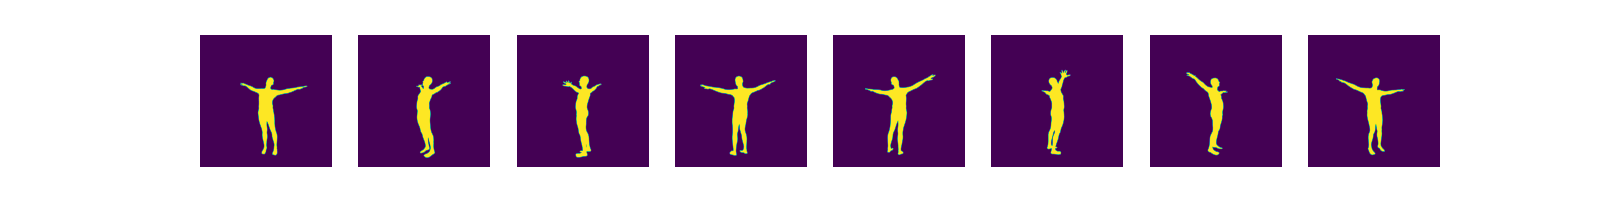

In [11]:
refImgs = []
fig, axs = plt.subplots(1, cfg.numCams)
fig.set_size_inches(cfg.numCams*2, 2)
with torch.no_grad():
    for iCam in range(cfg.numCams):
        R=camRTs[iCam]['R']
        T=camRTs[iCam]['T']
        image = renderRef.renderer(meshes_world=smplshMesh, R=R, T=T).cpu().numpy()
        image[np.where(image)] = 1
        axs[iCam].imshow(image[0,...,3], vmin=0.0, vmax=1.0)
        refImgs.append(image)
        axs[iCam].axis('off')
outTargetImgFile = join(outFolderForExperiment, 'TargetImg.png')
fig.savefig(outTargetImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)
outTargetImgFilePdf = join(outFolderForExperiment, 'TargetImg.pdf')
fig.savefig(outTargetImgFilePdf, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

saveVTK(join(outFolderMesh, 'Target.vtk'), verts.cpu().numpy(), smplshExampleMesh)

In [12]:


memStats = torch.cuda.memory_stats(device=device)
print('Before release: active_bytes.all.current:', memStats['active_bytes.all.current'] / 1000000)
torch.cuda.empty_cache()
memStats = torch.cuda.memory_stats(device=device)
print('After release: active_bytes.all.current:', memStats['active_bytes.all.current'] / 1000000)

Before release: active_bytes.all.current: 82.67264
After release: active_bytes.all.current: 82.67264


In [13]:
np.random.seed(cfg.randSeedPerturb)

if cfg.bodyJointOnly:
    numParameters = 3 * 22
else:
    numParameters = 3 * 52
# posePerturbed = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
# Keep hand fixed
if cfg.bodyJointOnly:
    poseHands = pose[numBodyParameters:].clone().detach()
    poseParams = torch.tensor(pose[:numBodyParameters].cpu().numpy() + (np.random.rand(numBodyParameters) - 0.5) * cfg.noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
    posePerturbed = torch.cat([poseParams, poseHands])
else:
    poseParams  = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * cfg.noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
    posePerturbed = poseParams

<IPython.core.display.Javascript object>


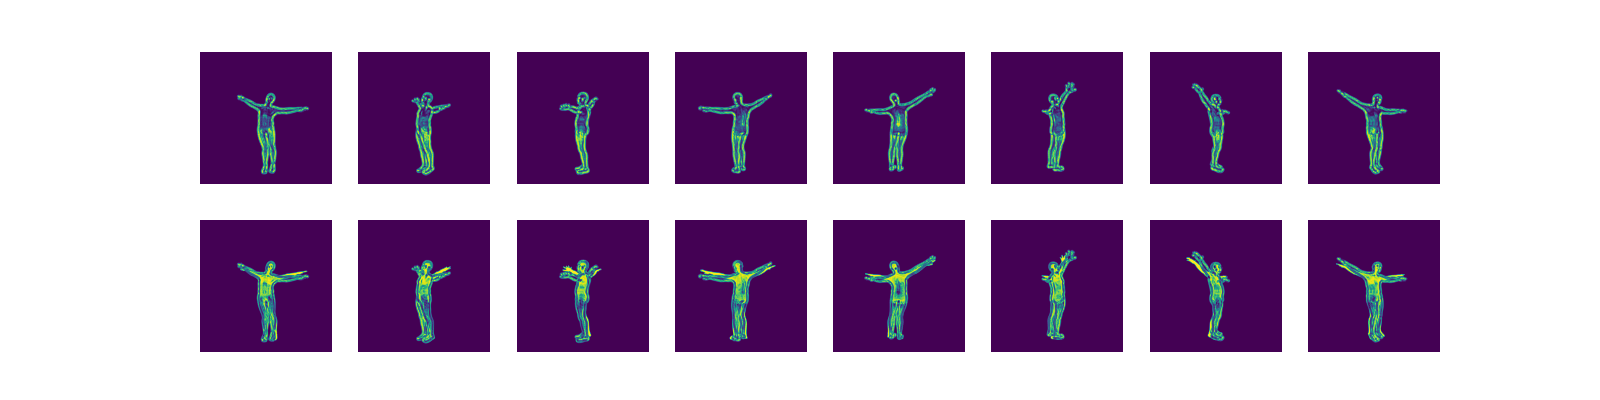

In [14]:
vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
images = renderMesh(camRTs, cfg, smplshMeshPerturbed, renderSynth)
        
outInitalImgFile = join(outFolderForExperiment, 'ZInitalImg.png')
# fig.savefig(outInitalImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)
loss = visualize2DResults(images, refImgs, cfg, outInitalImgFile)

In [16]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
print('Inital loss:', loss)
poses = []
losses = []

Inital loss: 1095656.6953125


In [17]:
optimizer = torch.optim.Adam([poseParams], lr=cfg.learningRate)
logger = configLogger()

NameError: name 'configLogger' is not defined

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


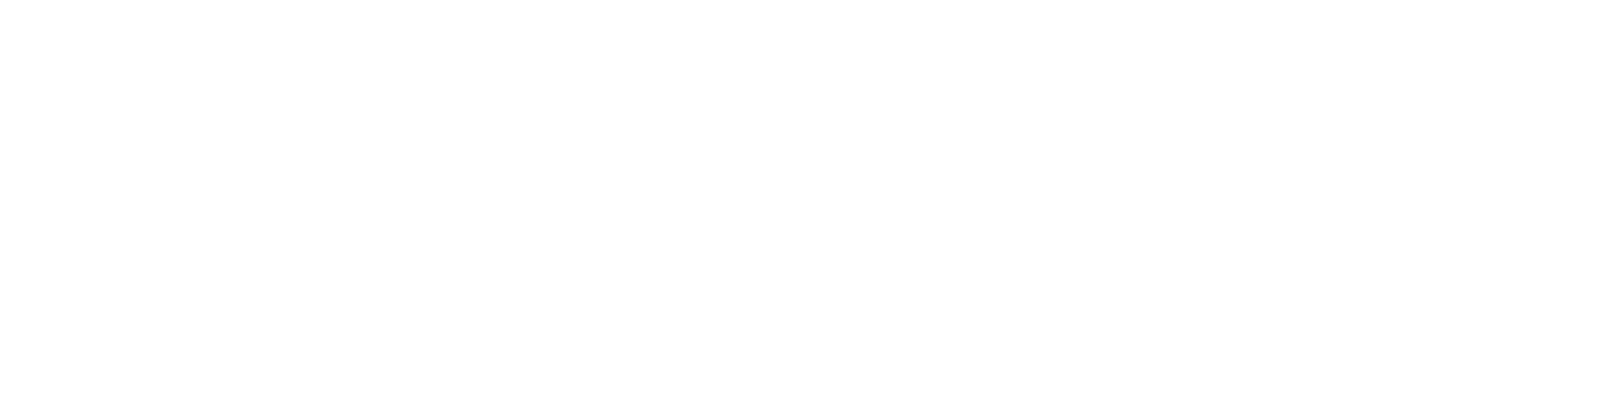

<IPython.core.display.Javascript object>


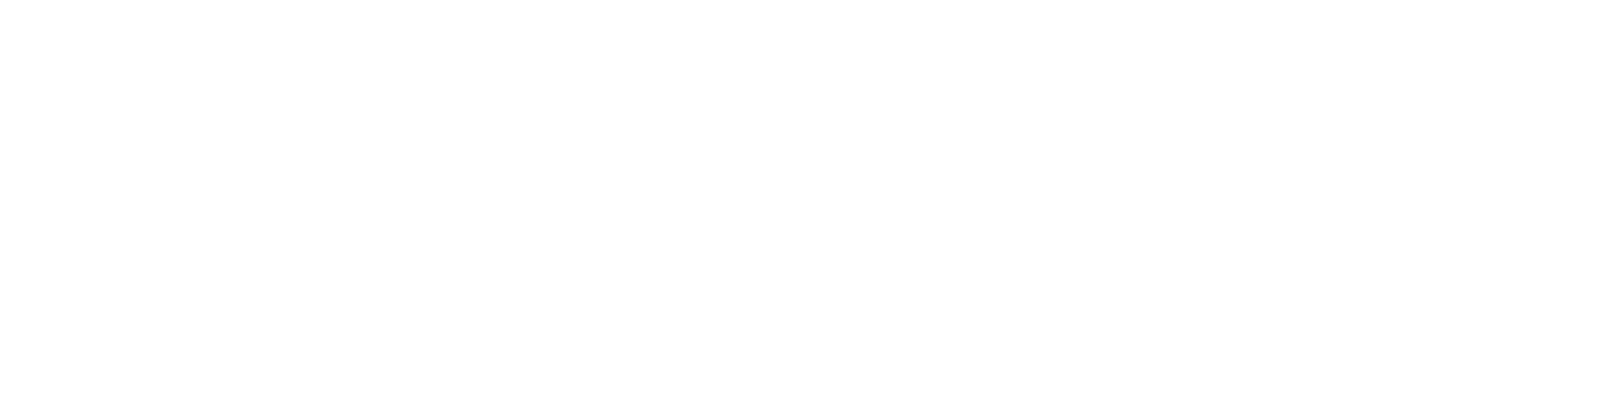

<IPython.core.display.Javascript object>


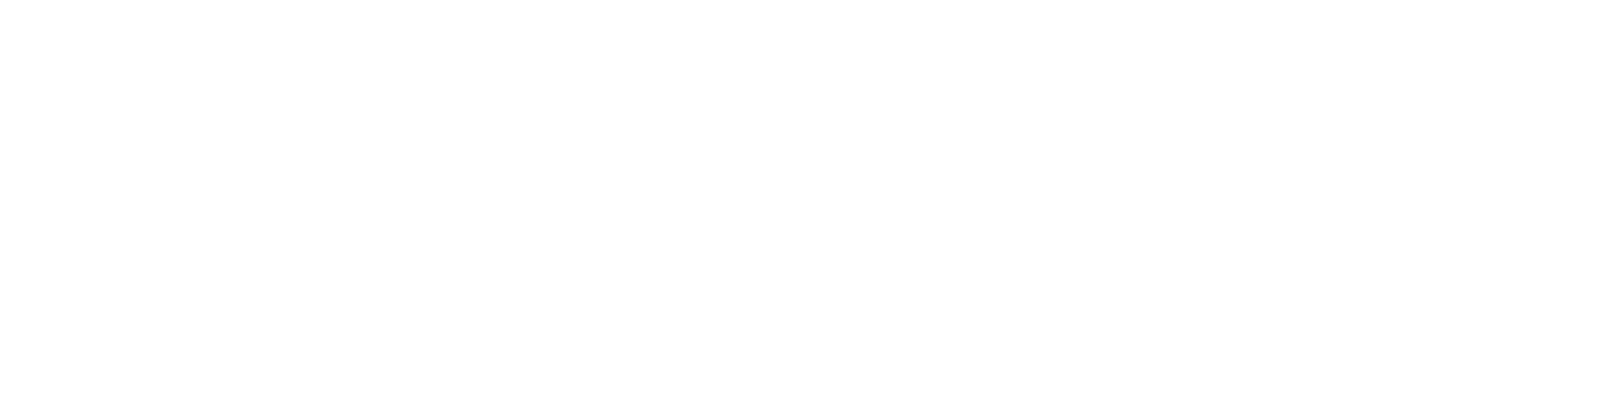

<IPython.core.display.Javascript object>


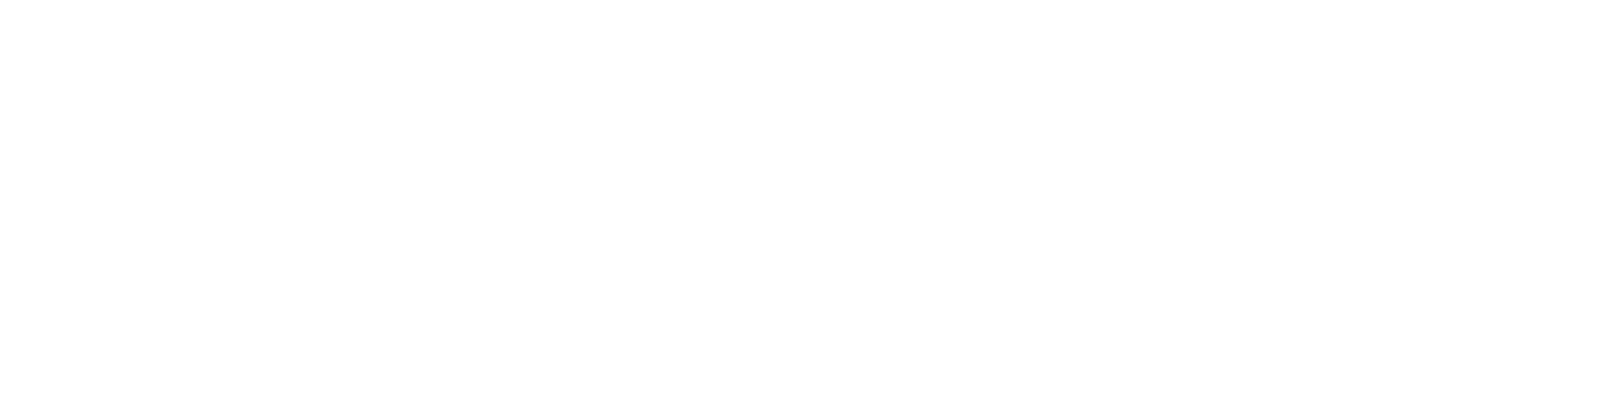

<IPython.core.display.Javascript object>


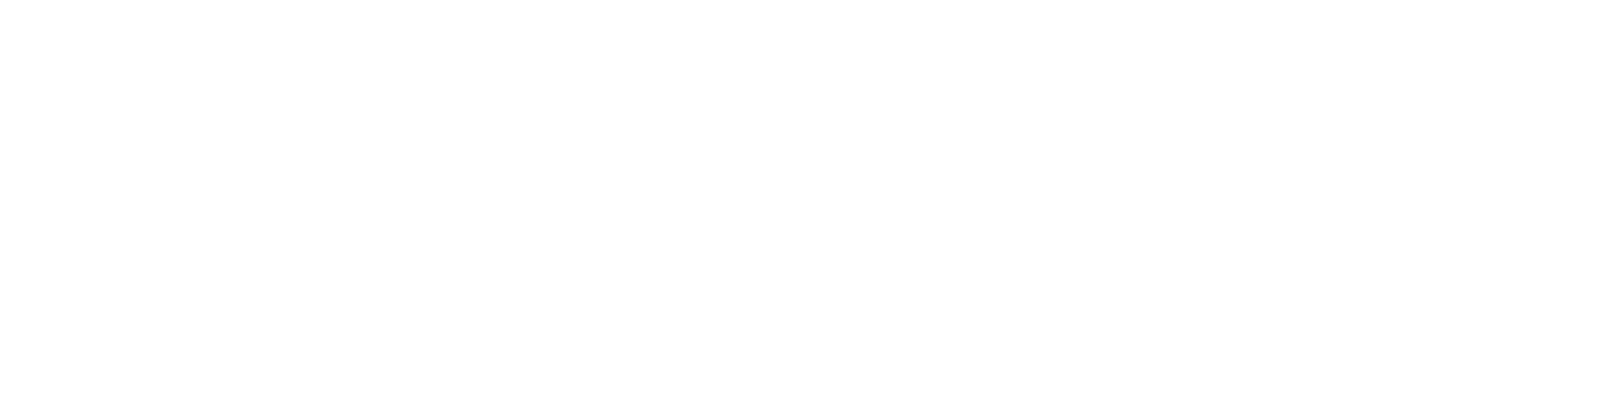

<IPython.core.display.Javascript object>


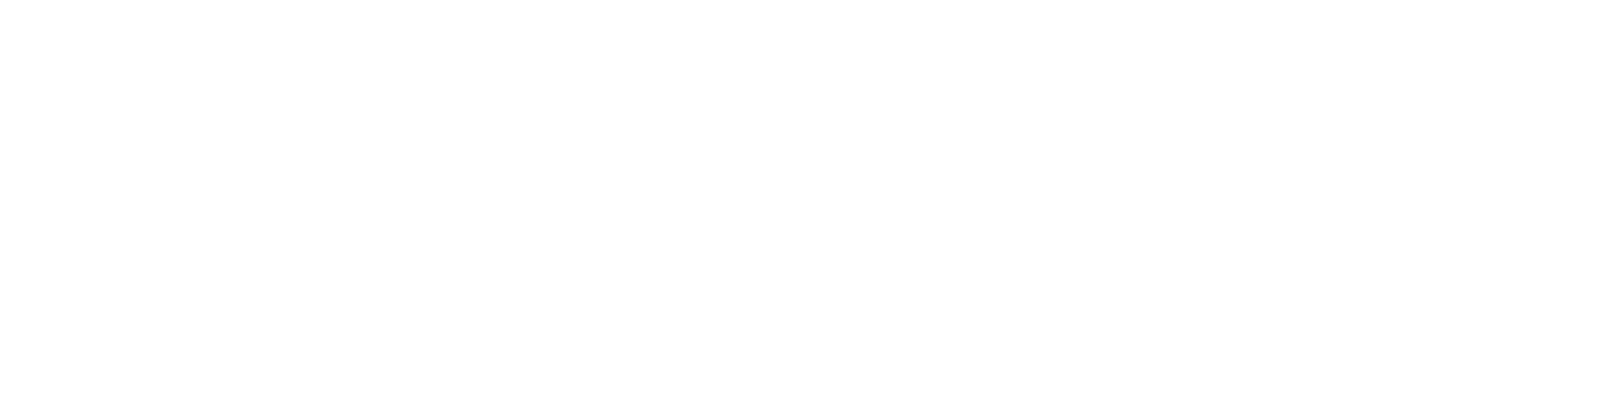

<IPython.core.display.Javascript object>


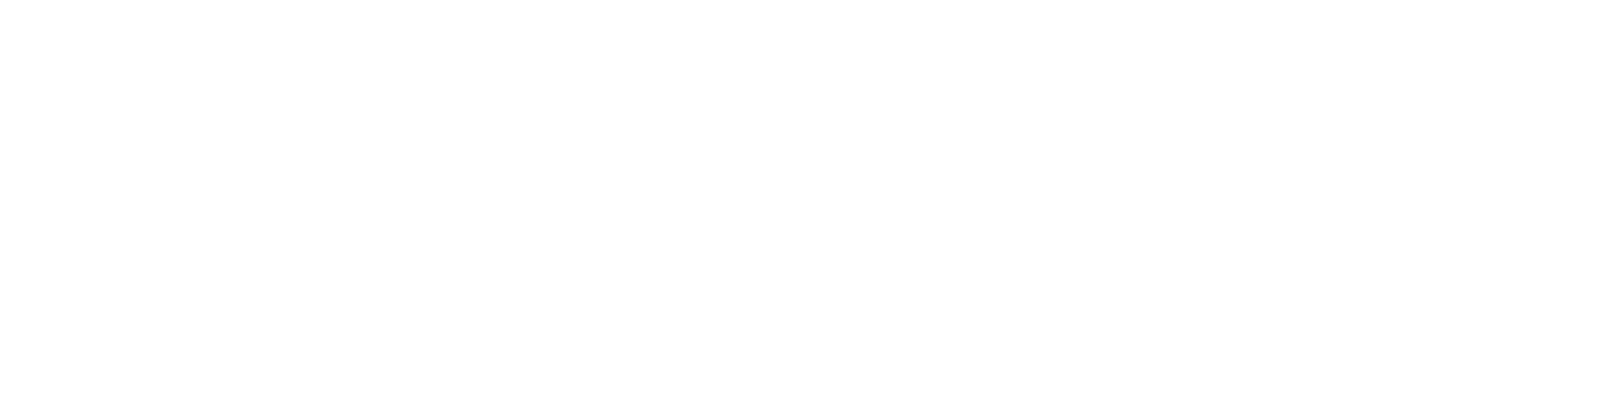

<IPython.core.display.Javascript object>


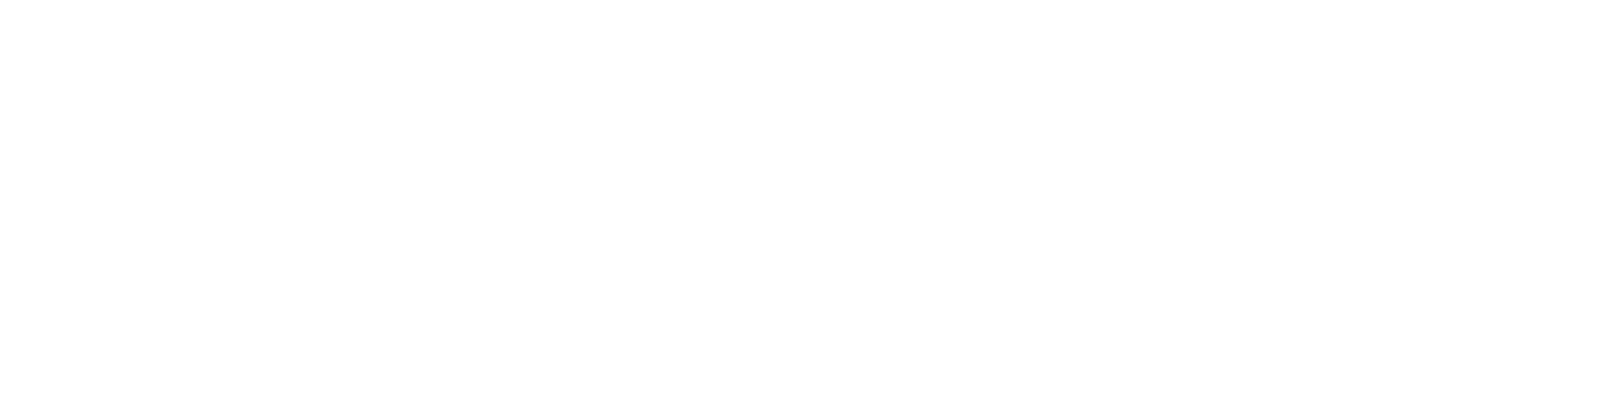

<IPython.core.display.Javascript object>

In [ ]:
loop = tqdm_notebook(range(cfg.numIterations))
for i in loop:
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    if cfg.bodyJointOnly:
#         poseHands = pose[numBodyParameters:].clone().detach()
        posePerturbed = torch.cat([poseParams, poseHands])
    else:
        posePerturbed = poseParams
    lossVal = 0
    for iCam in range(cfg.numCams):
        vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
        smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
        R=camRTs[iCam]['R']
        T=camRTs[iCam]['T']
        
        refImg = torch.tensor(refImgs[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        images = renderSynth.renderer(smplshMeshPerturbed,  R=R, T=T)

        loss = torch.sum((refImg - images[..., 3]) ** 2) / cfg.numCams
        loss.backward()
        lossVal += loss.item()
    
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    poses.append(posePerturbed.cpu().detach().numpy())
    
#     for cam in cameras:
#         image = render(...)
#     loss.backward()
        
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    
    dis3D = vertsPerturbed.cpu().detach().numpy() - verts.cpu().numpy()
    dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    loop.set_description('loss %.2f, 3D Dis:  %.2fmm, poseDiff: %.2f, MemUsed:%.2f' % (lossVal, dis3D*1000, torch.sum((pose-posePerturbed)**2).item(), memAllocated))
    
    if lossVal < cfg.terminateLoss:
        break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        # R = look_at_rotation(model.camera_position[None, :], device=model.device)
        # T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        # image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        # image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        # image = img_as_ubyte(image)
        # writer.append_data(image)
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        images = renderMesh(camRTs, cfg, smplshMeshPerturbed, renderSynth)
        visualize2DResults(images, refImgs, cfg, outImgFile)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), vertsPerturbed.cpu().detach().numpy(), smplshExampleMesh)
